
# Caplet and Floorlet 


---

## 1. Imports and OptionType Class

### Code:
```python
import numpy as np
import enum 
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.integrate as integrate

# Define option types (Call and Put)
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
```

### Quant Finance Explanation:
- **Imports:**  
  - **`numpy`**: for numerical operations.  
  - **`scipy.stats`**: for probability distributions.  
  - **`scipy.integrate`**: for numerical integration.  
  - **`matplotlib.pyplot`**: for plotting results.
- **OptionType Enum:**  
  - Defines two option types, where a call is represented by $1.0$ and a put by $-1.0$.

### Nitish Sir Hinglish Explanation:
- "Yeh libraries numerical calculations, integration, aur plotting ke liye use hoti hain. OptionType se hum decide karte hain ki option call hai ya put."

---

## 2. Function: `GeneratePathsHWEuler`

### Code:
```python
def GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta):    
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt)) - np.log(P0T(t-dt))) / (2*dt)
    r0 = f0T(0.00001)
    theta = lambda t: 1.0/lambd * (f0T(t+dt) - f0T(t-dt))/(2.0*dt) \
              + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    R[:,0] = r0
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(NoOfSteps):
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.sqrt(dt) * Z[:,i]
        R[:,i+1] = R[:,i] + lambd * (theta(time[i]) - R[:,i]) * dt \
                   + eta * (W[:,i+1]-W[:,i])
        time[i+1] = time[i] + dt
        
    return {"time": time, "R": R}
```

### Quant Finance Explanation:
- **Forward Rate Approximation:**  
  $$ f_0(t) \approx -\frac{\ln(P_0(t+dt)) - \ln(P_0(t-dt))}{2\,dt} $$
  This approximates the instantaneous forward rate from the market zero coupon bond curve $P_0(T)$.
- **Initial Rate:**  
  $$ r_0 = f_0(0.00001) $$
- **Drift Function ($\theta(t)$):**  
  $$ \theta(t) = \frac{1}{\lambda}\frac{f_0(t+dt)-f_0(t-dt)}{2\,dt} + f_0(t) + \frac{\eta^2}{2\lambda^2}\left(1-e^{-2\lambda t}\right) $$
- **Monte Carlo Simulation:**  
  - Generates standard normal random variables $Z$.  
  - Constructs the Wiener process $W$ via $W_{t+dt} = W_t + \sqrt{dt}\,Z_t$.  
  - Updates the short rate using the Euler scheme:  
    $$ R_{t+dt} = R_t + \lambda(\theta(t)-R_t)dt + \eta\, dW_t $$

### Nitish Sir Hinglish Explanation:
- "Yahan hum Hull-White model ke liye rate paths simulate kar rahe hain using Euler method. Pehle market curve se forward rate $f_0(t)$ calculate hota hai, phir initial rate $r_0$ set karte hain. Theta function se drift adjust hota hai aur random numbers se Wiener process banake, $R$ ko update karte hain."

---

## 3. Function: `HW_theta`

### Code:
```python
def HW_theta(lambd, eta, P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt)) - np.log(P0T(t-dt))) / (2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) \
              + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    return theta
```

### Quant Finance Explanation:
- Returns the drift function $\theta(t)$, calibrated as:
  $$ \theta(t) = \frac{1}{\lambda}\frac{f_0(t+dt)-f_0(t-dt)}{2\,dt} + f_0(t) + \frac{\eta^2}{2\lambda^2}(1-e^{-2\lambda t}) $$

### Nitish Sir Hinglish Explanation:
- "Yeh function $\theta(t)$ calculate karta hai jo market curve se derive hota hai aur model ko calibrate karta hai."

---

## 4. Function: `HW_A`

### Code:
```python
def HW_A(lambd, eta, P0T, T1, T2):
    tau = T2 - T1
    zGrid = np.linspace(0.0, tau, 250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd * tau) - 1.0)
    theta = HW_theta(lambd, eta, P0T)    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid), zGrid)
    temp2 = eta*eta/(4.0*np.power(lambd, 3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) - 3.0) \
            + eta*eta*tau/(2.0*lambd*lambd)
    return temp1 + temp2
```

### Quant Finance Explanation:
- Calculates the $A$ factor used in ZCB pricing:
  $$ P(t,T) = \exp\Bigl(A(t,T) - B(t,T)r_t\Bigr) $$
- **Drift Contribution:**  
  $$ \text{temp1} = \lambda \int_0^{\tau} \theta(T_2-z)\,B(z)\,dz $$
- **Volatility Contribution:**  
  $$ \text{temp2} = \frac{\eta^2}{4\lambda^3}\Bigl(e^{-2\lambda\tau}(4e^{\lambda\tau}-1)-3\Bigr) + \frac{\eta^2\tau}{2\lambda^2} $$

### Nitish Sir Hinglish Explanation:
- "Yeh function $A$ factor calculate karta hai jo bond pricing mein use hota hai. Pehle theta ke integration se drift effect nikala, phir volatility ka adjustment add kiya."

---

## 5. Function: `HW_B`

### Code:
```python
def HW_B(lambd, eta, T1, T2):
    return 1.0/lambd * (np.exp(-lambd*(T2-T1)) - 1.0)
```

### Quant Finance Explanation:
- Computes the $B$ factor:
  $$ B(T_1,T_2) = \frac{1}{\lambda}\left(e^{-\lambda (T_2-T_1)}-1\right) $$

### Nitish Sir Hinglish Explanation:
- "Yeh function $B$ factor deta hai jo bond price ko short rate ke sensitivity se jodta hai."

---

## 6. Function: `HW_ZCB`

### Code:
```python
def HW_ZCB(lambd, eta, P0T, T1, T2, rT1):
    B_r = HW_B(lambd, eta, T1, T2)
    A_r = HW_A(lambd, eta, P0T, T1, T2)
    return np.exp(A_r + B_r * rT1)
```

### Quant Finance Explanation:
- Prices a zero coupon bond using the affine formula:
  $$ P(t,T) = \exp\Bigl(A(t,T) - B(t,T)r_t\Bigr) $$
  *(Note: The sign convention in the exponent might vary between formulations.)*

### Nitish Sir Hinglish Explanation:
- "Yeh function ZCB ka price nikalta hai using $A$ aur $B$ factors. Exponential form mein $A + B \times r_{T1}$ se price determine hota hai."

---

## 7. Function: `HWMean_r`

### Code:
```python
def HWMean_r(P0T, lambd, eta, T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt)) - np.log(P0T(t-dt)))/(2.0*dt)
    r0 = f0T(0.00001)
    theta = HW_theta(lambd, eta, P0T)
    zGrid = np.linspace(0.0, T, 2500)
    temp = lambda z: theta(z) * np.exp(-lambd*(T-z))
    r_mean = r0*np.exp(-lambd*T) + lambd * integrate.trapz(temp(zGrid), zGrid)
    return r_mean
```

### Quant Finance Explanation:
- Computes the expected short rate at time $T$:
  $$ \mathbb{E}[r_T] = r_0e^{-\lambda T} + \lambda\int_0^T \theta(z)e^{-\lambda(T-z)}dz $$

### Nitish Sir Hinglish Explanation:
- "Yeh function future time $T$ pe expected short rate calculate karta hai, jisme initial rate ka decay aur drift (theta) ka integrated effect hota hai."

---

## 8. Function: `HW_r_0`

### Code:
```python
def HW_r_0(P0T, lambd, eta):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt)) - np.log(P0T(t-dt)))/(2*dt)
    r0 = f0T(0.00001)
    return r0
```

### Quant Finance Explanation:
- Returns the initial short rate $r_0$, derived using the forward rate approximation.

### Nitish Sir Hinglish Explanation:
- "Yeh function bas initial rate $r_0$ return karta hai jo market curve se nikalta hai."

---

## 9. Function: `HW_Mu_FrwdMeasure`

### Code:
```python
def HW_Mu_FrwdMeasure(P0T, lambd, eta, T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt)) - np.log(P0T(t-dt)))/(2*dt)
    r0 = f0T(0.00001)
    theta = HW_theta(lambd, eta, P0T)
    zGrid = np.linspace(0.0, T, 500)
    theta_hat = lambda t, T: theta(t) + eta*eta/(lambd*lambd)*(np.exp(-lambd*(T-t))-1.0)
    temp = lambda z: theta_hat(z, T) * np.exp(-lambd*(T-z))
    r_mean = r0*np.exp(-lambd*T) + lambd * integrate.trapz(temp(zGrid), zGrid)
    return r_mean
```

### Quant Finance Explanation:
- Adjusts the drift under the forward measure using:
  $$ \hat{\theta}(t,T) = \theta(t) + \frac{\eta^2}{\lambda^2}\Bigl(e^{-\lambda(T-t)}-1\Bigr) $$
- Then computes the mean rate under the forward measure similarly as before.

### Nitish Sir Hinglish Explanation:
- "Yahan forward measure ke liye drift adjust karke, expected rate calculate karte hain, jo option pricing mein use hota hai."

---

## 10. Function: `HWVar_r`

### Code:
```python
def HWVar_r(lambd, eta, T):
    return eta*eta/(2.0*lambd) * (1.0 - np.exp(-2.0*lambd * T))
```

### Quant Finance Explanation:
- Computes the variance of the short rate:
  $$ \text{Var}(r_T) = \frac{\eta^2}{2\lambda}\Bigl(1-e^{-2\lambda T}\Bigr) $$

### Nitish Sir Hinglish Explanation:
- "Yeh function short rate ki variance calculate karta hai, jo volatility effect ko capture karta hai."

---

## 11. Function: `HWDensity`

### Code:
```python
def HWDensity(P0T, lambd, eta, T):
    r_mean = HWMean_r(P0T, lambd, eta, T)
    r_var = HWVar_r(lambd, eta, T)
    return lambda x: st.norm.pdf(x, r_mean, np.sqrt(r_var))
```

### Quant Finance Explanation:
- Returns a probability density function for $r_T$ using the normal distribution:
  $$ p(x) = \frac{1}{\sqrt{2\pi\,\text{Var}(r_T)}}\exp\left(-\frac{(x-\mathbb{E}[r_T])^2}{2\,\text{Var}(r_T)}\right) $$

### Nitish Sir Hinglish Explanation:
- "Yeh function normal distribution ka PDF return karta hai jisme mean aur variance pehle se calculate ho chuke hain."

---

## 12. Function: `HW_CapletFloorletPrice`

### Code:
```python
def HW_CapletFloorletPrice(CP, N, K, lambd, eta, P0T, T1, T2):
    if CP == OptionType.CALL:
        N_new = N * (1.0 + (T2 - T1) * K)
        K_new = 1.0 + (T2 - T1) * K
        caplet = N_new * HW_ZCB_CallPutPrice(OptionType.PUT, 1.0 / K_new, lambd, eta, P0T, T1, T2)
        value = caplet
    elif CP == OptionType.PUT:
        value = 0.0  # To be implemented
    return value
```

### Quant Finance Explanation:
- Prices a caplet by relating it to a put option on a ZCB with adjusted parameters:
  - Adjusted notional:  
    $$ N_{\text{new}} = N(1+(T_2-T_1)K) $$
  - Adjusted strike:  
    $$ K_{\text{new}} = 1+(T_2-T_1)K $$
- Caplet price is computed as:  
  $$ \text{Caplet Price} = N_{\text{new}} \times \text{Price}\Bigl(\text{PUT on ZCB with strike } \frac{1}{K_{\text{new}}}\Bigr) $$

### Nitish Sir Hinglish Explanation:
- "Yeh function caplet ka price calculate karta hai by adjusting notional and strike, aur fir put option ke price se value derive karta hai."

---

## 13. Function: `HW_ZCB_CallPutPrice`

### Code:
```python
def HW_ZCB_CallPutPrice(CP, K, lambd, eta, P0T, T1, T2):
    B_r = HW_B(lambd, eta, T1, T2)
    A_r = HW_A(lambd, eta, P0T, T1, T2)
    mu_r = HW_Mu_FrwdMeasure(P0T, lambd, eta, T1)
    v_r = np.sqrt(HWVar_r(lambd, eta, T1))
    K_hat = K * np.exp(-A_r)
    a = (np.log(K_hat) - B_r * mu_r) / (B_r * v_r)
    d1 = a - B_r * v_r
    d2 = d1 + B_r * v_r
    term1 = np.exp(0.5 * B_r * B_r * v_r * v_r + B_r * mu_r) * st.norm.cdf(d1) - K_hat * st.norm.cdf(d2)
    value = P0T(T1) * np.exp(A_r) * term1
    if CP == OptionType.CALL:
        return value
    elif CP == OptionType.PUT:
        return value - P0T(T2) + K * P0T(T1)
```

### Quant Finance Explanation:
- Prices an option on a ZCB by adapting Black’s formula:
  - Adjusted strike:  
    $$ \hat{K} = K\,e^{-A_r} $$
  - Compute intermediary variables:
    $$ a = \frac{\ln(\hat{K})-B_r\,\mu_r}{B_r\,v_r},\quad d_1 = a - B_r\,v_r,\quad d_2 = d_1+B_r\,v_r $$
- The option value is then calculated and adjusted for call or put.

### Nitish Sir Hinglish Explanation:
- "Yeh function ZCB par option ka price nikalta hai by computing adjusted strike, d1, d2 using logarithms and volatility, aur final value mein market bond price aur exponential adjustment add hota hai."

---

## 14. Function: `mainCalculation`

### Code:
```python
def mainCalculation():
    CP = OptionType.CALL
    NoOfPaths = 20000
    NoOfSteps = 1000
        
    lambd = 0.02
    eta = 0.02
    
    # Market zero coupon bond curve
    P0T = lambda T: np.exp(-0.1 * T)
    r0 = HW_r_0(P0T, lambd, eta)
    
    # Compare Analytical vs. Monte Carlo ZCB Prices
    N = 25
    T_end = 50
    Tgrid = np.linspace(0, T_end, N)
    
    Exact = np.zeros([N, 1])
    Proxy = np.zeros([N, 1])
    for i, Ti in enumerate(Tgrid):
        Proxy[i] = HW_ZCB(lambd, eta, P0T, 0.0, Ti, r0)
        Exact[i] = P0T(Ti)
        
    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid, Exact, '-k')
    plt.plot(Tgrid, Proxy, '--r')
    plt.legend(["Analytical ZCB", "Monte Carlo ZCB"])
    plt.title('P(0,T) from Monte Carlo vs. Analytical expression')

    # Option Pricing on ZCB
    T1 = 4.0
    T2 = 8.0
    paths = GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T1, P0T, lambd, eta)
    r = paths["R"]
    timeGrid = paths["time"]
    dt = timeGrid[1] - timeGrid[0]
    
    M_t = np.zeros([NoOfPaths, NoOfSteps])
    for i in range(NoOfPaths):
        M_t[i, :] = np.exp(np.cumsum(r[i, :-1]) * dt)
        
    KVec = np.linspace(0.01, 1.7, 50)
    Price_MC_V = np.zeros([len(KVec), 1])
    Price_Th_V = np.zeros([len(KVec), 1])
    P_T1_T2 = HW_ZCB(lambd, eta, P0T, T1, T2, r[:, -1])
    for i, K in enumerate(KVec):
        if CP == OptionType.CALL:
            Price_MC_V[i] = np.mean(1.0 / M_t[:, -1] * np.maximum(P_T1_T2 - K, 0.0))
        elif CP == OptionType.PUT:
            Price_MC_V[i] = np.mean(1.0 / M_t[:, -1] * np.maximum(K - P_T1_T2, 0.0))
        Price_Th_V[i] = HW_ZCB_CallPutPrice(CP, K, lambd, eta, P0T, T1, T2)
        
    plt.figure(2)
    plt.grid()
    plt.plot(KVec, Price_MC_V)
    plt.plot(KVec, Price_Th_V, '--r')
    plt.legend(['Monte Carlo', 'Theoretical'])
    plt.title('Option on ZCB')

    # Caplet Pricing
    frwd = 1.0 / (T2 - T1) * (P0T(T1) / P0T(T2) - 1.0)
    K = np.linspace(frwd / 2.0, 3.0 * frwd, 25)
    Notional = 1.0
    capletPrice = np.zeros(len(K))
    for idx in range(len(K)):
           capletPrice[idx] = HW_CapletFloorletPrice(CP, Notional, K[idx], lambd, eta, P0T, T1, T2)
           
    plt.figure(3)
    plt.title('Caplet Price')
    plt.plot(K, capletPrice)
    plt.xlabel('strike')
    plt.ylabel('Caplet Price')
    plt.grid()
    
mainCalculation()
```

### Quant Finance Explanation:
- **Driver Function:**  
  - Sets parameters (number of paths, time steps, $\lambda$, $\eta$) and defines the market zero coupon bond curve $P_0(T)=e^{-0.1T}$.  
  - Compares analytical ZCB prices with Monte Carlo simulation results.  
  - Computes option prices on a ZCB over various strikes and also derives caplet prices.
- **Visualization:**  
  - Multiple plots are generated to compare analytical and simulated results.

### Nitish Sir Hinglish Explanation:
- "Yeh `mainCalculation()` function poore simulation aur pricing ka driver hai.  
- Parameters set karte hain, market curve define karte hain, analytical aur Monte Carlo results compare karte hain, aur phir option pricing aur caplet pricing ke plots banate hain."

---

## Final Interview and Model-Building Tips

- **Understand Model Dynamics:**  
  - Study the Hull-White model’s mean reversion, volatility structure, and calibration to the market curve.
- **Practice Coding:**  
  - Build similar models, experiment with parameters, and compare outputs with market data.
- **Clear Explanations:**  
  - Simplify your explanation during interviews using intuitive reasoning behind each formula.
- **Industry Practices:**  
  - Calibration, simulation, and theoretical pricing are key in quant finance.
- **Nitish Sir Style:**  
  - "Clear concepts, simple explanations, aur hard work se aap interview mein zaroor success paoge!"

---


```

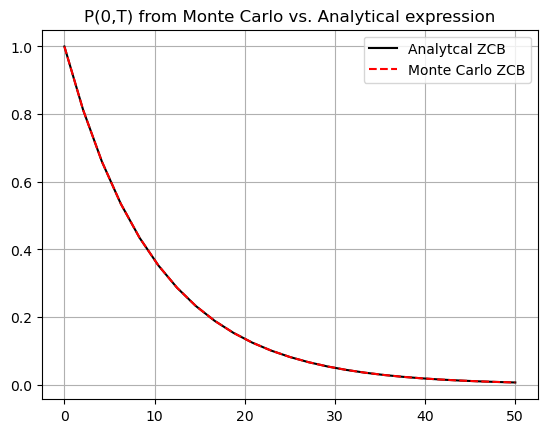

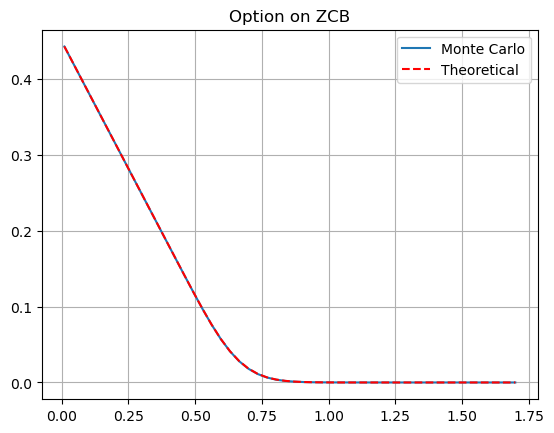

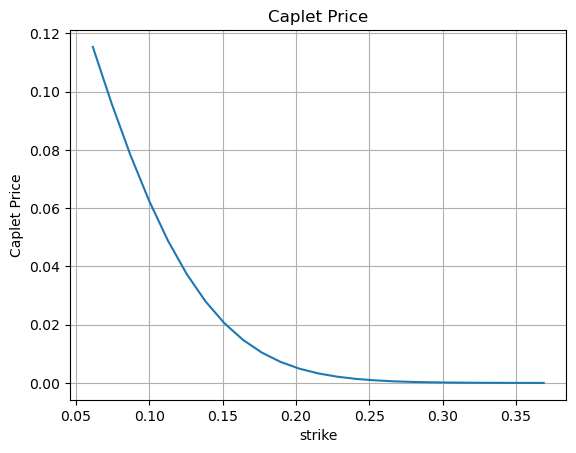

In [1]:
import numpy as np
import enum
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate


# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0


def GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)

    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = lambda t: 1.0 / lambd * (f0T(t + dt) - f0T(t - dt)) / (2.0 * dt) + f0T(t) + eta * eta / (
                2.0 * lambd * lambd) * (1.0 - np.exp(-2.0 * lambd * t))

    # theta = lambda t: 0.1 +t -t
    # print("changed theta")

    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    R = np.zeros([NoOfPaths, NoOfSteps + 1])
    R[:, 0] = r0
    time = np.zeros([NoOfSteps + 1])

    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i + 1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]
        R[:, i + 1] = R[:, i] + lambd * (theta(time[i]) - R[:, i]) * dt + eta * (W[:, i + 1] - W[:, i])
        time[i + 1] = time[i] + dt

    # Outputs
    paths = {"time": time, "R": R}
    return paths


def HW_theta(lambd, eta, P0T):
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    theta = lambda t: 1.0 / lambd * (f0T(t + dt) - f0T(t - dt)) / (2.0 * dt) + f0T(t) + eta * eta / (
                2.0 * lambd * lambd) * (1.0 - np.exp(-2.0 * lambd * t))
    # print("CHANGED THETA")
    return theta  # lambda t: 0.1+t-t


def HW_A(lambd, eta, P0T, T1, T2):
    tau = T2 - T1
    zGrid = np.linspace(0.0, tau, 250)
    B_r = lambda tau: 1.0 / lambd * (np.exp(-lambd * tau) - 1.0)
    theta = HW_theta(lambd, eta, P0T)
    temp1 = lambd * integrate.trapz(theta(T2 - zGrid) * B_r(zGrid), zGrid)

    temp2 = eta * eta / (4.0 * np.power(lambd, 3.0)) * (
                np.exp(-2.0 * lambd * tau) * (4 * np.exp(lambd * tau) - 1.0) - 3.0) + eta * eta * tau / (
                        2.0 * lambd * lambd)

    return temp1 + temp2


def HW_B(lambd, eta, T1, T2):
    return 1.0 / lambd * (np.exp(-lambd * (T2 - T1)) - 1.0)


def HW_ZCB(lambd, eta, P0T, T1, T2, rT1):
    B_r = HW_B(lambd, eta, T1, T2)
    A_r = HW_A(lambd, eta, P0T, T1, T2)
    return np.exp(A_r + B_r * rT1)


def HWMean_r(P0T, lambd, eta, T):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2.0 * dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = HW_theta(lambd, eta, P0T)
    zGrid = np.linspace(0.0, T, 2500)
    temp = lambda z: theta(z) * np.exp(-lambd * (T - z))
    r_mean = r0 * np.exp(-lambd * T) + lambd * integrate.trapz(temp(zGrid), zGrid)
    return r_mean


def HW_r_0(P0T, lambd, eta):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    return r0


def HW_Mu_FrwdMeasure(P0T, lambd, eta, T):
    # time-step needed for differentiation
    dt = 0.0001
    f0T = lambda t: - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = HW_theta(lambd, eta, P0T)
    zGrid = np.linspace(0.0, T, 500)

    theta_hat = lambda t, T: theta(t) + eta * eta / lambd * 1.0 / lambd * (np.exp(-lambd * (T - t)) - 1.0)

    temp = lambda z: theta_hat(z, T) * np.exp(-lambd * (T - z))

    r_mean = r0 * np.exp(-lambd * T) + lambd * integrate.trapz(temp(zGrid), zGrid)

    return r_mean


def HWVar_r(lambd, eta, T):
    return eta * eta / (2.0 * lambd) * (1.0 - np.exp(-2.0 * lambd * T))


def HWDensity(P0T, lambd, eta, T):
    r_mean = HWMean_r(P0T, lambd, eta, T)
    r_var = HWVar_r(lambd, eta, T)
    return lambda x: stats.norm.pdf(x, r_mean, np.sqrt(r_var))


def HW_CapletFloorletPrice(CP, N, K, lambd, eta, P0T, T1, T2):
    if CP == OptionType.CALL:
        N_new = N * (1.0 + (T2 - T1) * K)
        K_new = 1.0 + (T2 - T1) * K
        caplet = N_new * HW_ZCB_CallPutPrice(OptionType.PUT, 1.0 / K_new, lambd, eta, P0T, T1, T2)
        value = caplet
    elif CP == OptionType.PUT:
       # Adjusted notional and strike parameters
        N_new = N * (1.0 + (T2 - T1) * K)
        K_new = 1.0 + (T2 - T1) * K
        # Compute floorlet price by using the call price function for the underlying ZCB option.
        # (Note: For a floorlet, the sign is reversed relative to a caplet.)
        floorlet = N_new * HW_ZCB_CallPutPrice(OptionType.CALL, 1.0 / K_new, lambd, eta, P0T, T1, T2)
        value = floorlet
    return value


def HW_ZCB_CallPutPrice(CP, K, lambd, eta, P0T, T1, T2):
    B_r = HW_B(lambd, eta, T1, T2)
    A_r = HW_A(lambd, eta, P0T, T1, T2)

    mu_r = HW_Mu_FrwdMeasure(P0T, lambd, eta, T1)
    v_r = np.sqrt(HWVar_r(lambd, eta, T1))

    K_hat = K * np.exp(-A_r)

    a = (np.log(K_hat) - B_r * mu_r) / (B_r * v_r)

    d1 = a - B_r * v_r
    d2 = d1 + B_r * v_r

    term1 = np.exp(0.5 * B_r * B_r * v_r * v_r + B_r * mu_r) * stats.norm.cdf(d1) - K_hat * stats.norm.cdf(d2)
    value = P0T(T1) * np.exp(A_r) * term1

    if CP == OptionType.CALL:
        return value
    elif CP == OptionType.PUT:
        return value - P0T(T2) + K * P0T(T1)


def mainCalculation():
    CP = OptionType.CALL
    NoOfPaths = 20000
    NoOfSteps = 1000

    lambd = 0.02

    eta = 0.02

    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.1 * T)  # np.exp(-0.03*T*T-0.1*T)
    r0 = HW_r_0(P0T, lambd, eta)

    # In this experiment we compare ZCB from the Market and Analytical expression
    N = 25
    T_end = 50
    Tgrid = np.linspace(0, T_end, N)

    Exact = np.zeros([N, 1])
    Proxy = np.zeros([N, 1])
    for i, Ti in enumerate(Tgrid):
        Proxy[i] = HW_ZCB(lambd, eta, P0T, 0.0, Ti, r0)
        Exact[i] = P0T(Ti)

    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid, Exact, '-k')
    plt.plot(Tgrid, Proxy, '--r')
    plt.legend(["Analytcal ZCB", "Monte Carlo ZCB"])
    plt.title('P(0,T) from Monte Carlo vs. Analytical expression')

    # In this experiment we compare Monte Carlo results for
    T1 = 4.0
    T2 = 8.0

    paths = GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T1, P0T, lambd, eta)
    r = paths["R"]
    timeGrid = paths["time"]
    dt = timeGrid[1] - timeGrid[0]

    # Here we compare the price of an option on a ZCB from Monte Carlo and Analytical expression
    M_t = np.zeros([NoOfPaths, NoOfSteps])
    for i in range(0, NoOfPaths):
        M_t[i, :] = np.exp(np.cumsum(r[i, :-1]) * dt)

    KVec = np.linspace(0.01, 1.7, 50)
    Price_MC_V = np.zeros([len(KVec), 1])
    Price_Th_V = np.zeros([len(KVec), 1])
    P_T1_T2 = HW_ZCB(lambd, eta, P0T, T1, T2, r[:, -1])
    for i, K in enumerate(KVec):
        if CP == OptionType.CALL:
            Price_MC_V[i] = np.mean(1.0 / M_t[:, -1] * np.maximum(P_T1_T2 - K, 0.0))
        elif CP == OptionType.PUT:
            Price_MC_V[i] = np.mean(1.0 / M_t[:, -1] * np.maximum(K - P_T1_T2, 0.0))
        Price_Th_V[i] = HW_ZCB_CallPutPrice(CP, K, lambd, eta, P0T, T1, T2)  # HW_ZCB_CallPrice(K,lambd,eta,P0T,T1,T2)

    plt.figure(2)
    plt.grid()
    plt.plot(KVec, Price_MC_V)
    plt.plot(KVec, Price_Th_V, '--r')
    plt.legend(['Monte Carlo', 'Theoretical'])
    plt.title('Option on ZCB')

    # Effect of the HW model parameters on Implied Volatilities
    # define a forward rate between T1 and T2
    frwd = 1.0 / (T2 - T1) * (P0T(T1) / P0T(T2) - 1.0)
    K = np.linspace(frwd / 2.0, 3.0 * frwd, 25)
    Notional = 1.0

    capletPrice = np.zeros(len(K))
    for idx in range(0, len(K)):
        capletPrice[idx] = HW_CapletFloorletPrice(CP, Notional, K[idx], lambd, eta, P0T, T1, T2)

    plt.figure(3)
    plt.title('Caplet Price')
    plt.plot(K, capletPrice)
    plt.xlabel('strike')
    plt.ylabel('Caplet Price')
    plt.grid()


mainCalculation()